# Model Comparisons

Now that I've implemented 3 main classes of collaborative filtering methods (similarity-based, alternating least squares (ALS), and stochastic gradient descent (SGD)), it's time to see how they stack up to each other.

To compare models, I'll use 2 different metrics: mean absolute error (MAE) and normalized discounted cumulative gain (NDCG). MAE measures about how many stars off all the predictions are on average. This is useful information, but in most recommendation situations, the user will only see a few of the top recommendations given to them. The NDCG score tells us how "good" the top few recommendations are, with decreasing weight given the farther you go down the list.

Usually, NDCG will be reported for a certain number of recommendations. If we just care about the first 3 recommendations, we would computer NDCG@3. If there were no movies that the user would have rated more highly than these 3, then NDCG@3 is 1.0. Lower values mean other movies would have gotten higher ratings.

If you're interested, the math looks like this:

Given a vector $\mathbf{r}$ of $k$ recommendations from most to least recommended, discounted cumulative gain (DCG) is given by:

$$DCG@k = \sum_{i=1}^k \frac{r_i}{\log_2(i+1)}$$

Normalized DCG (NDCG) is just DCG divided by the maximum possible DCG:

$$ NDCG@k = \frac{DCG@k}{\max_{\mathbf{r}} DCG@k}$$

In [1]:
# <!-- collapse=True -->
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# <!-- collapse=True -->
from datetime import datetime
from functools import reduce
from os.path import exists
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from cf_utils import ALSRecommender
from cf_utils import DampedUserMovieBaselineModel
from cf_utils import KNNRecommender
from cf_utils import ndcg_from_df
from cf_utils import SGDRecommender

# Use custom matplotlib stylesheet
plt.style.use('./big-darkgrid.mplstyle')

# 2. Load the Data

Let's load and examine the ratings data. If you're following along (i.e. actually running these notebooks) you'll need to make sure to run the first one to download the data before running this one.

In [3]:
# <!-- collapse=True -->
ratings_df = pd.read_csv('raw/ml-100k/u.data', sep='\t', header=None, 
                         names=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)
ratings_df = ratings_df.sort_values('timestamp')
print('First 5:')
display(ratings_df.head())
print()
print('Last 5:')
display(ratings_df.tail())

First 5:


,userId,movieId,rating,timestamp
214,259,255,4,1997-09-19 23:05:10
83965,259,286,4,1997-09-19 23:05:27
43027,259,298,4,1997-09-19 23:05:54
21396,259,185,4,1997-09-19 23:06:21
82655,259,173,4,1997-09-19 23:07:23



Last 5:


,userId,movieId,rating,timestamp
46773,729,689,4,1998-04-22 19:10:38
73008,729,313,3,1998-04-22 19:10:38
46574,729,328,3,1998-04-22 19:10:38
64312,729,748,4,1998-04-22 19:10:38
79208,729,272,4,1998-04-22 19:10:38


In [4]:
# <!-- collapse=True -->
n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, random_state=0)
splits = [
    (train_inds, test_inds)
    for train_inds, test_inds in skf.split(ratings_df, ratings_df['userId'])
]

In [5]:
# <!-- collapse=True -->
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    train_movie_counts = train_df.groupby('userId').movieId.count()
    test_movie_counts = test_df.groupby('userId').movieId.count()
    print("Fold {}:".format(i_fold))
    train_min, train_max = train_movie_counts.min(), train_movie_counts.max()
    test_min, test_max = test_movie_counts.min(), test_movie_counts.max()
    print("  Train: between {} and {} movies per user".format(train_min, train_max))
    print("  Test:  between {} and {} movies per user".format(test_min, test_max))

Fold 0:
  Train: between 13 and 491 movies per user
  Test:  between 7 and 246 movies per user
Fold 1:
  Train: between 13 and 491 movies per user
  Test:  between 7 and 246 movies per user
Fold 2:
  Train: between 14 and 492 movies per user
  Test:  between 6 and 245 movies per user


In [6]:
def cart_prod(df_1, df_2):
    df_1['_dummy_'], df_2['_dummy_'] = 1, 1
    return pd.merge(df_1, df_2, on='_dummy_').drop('_dummy_', axis=1)

In [7]:
def prep_results_df(lists_dict):
    df = pd.DataFrame({'_dummy_': [1]})
    for name, list in lists_dict.items():
        df = cart_prod(df, pd.DataFrame({name: list}))
    return df

# 3. Choose the best user-based model

Let's use cross-validation to examine MAE and NDCG@3 on out-of-sample data and choose the "best" user-based model.

In [8]:
lists_dict = {
    'i_fold': np.arange(n_splits),
    'k': [1, 2, 5, 10, 20, 50, 100],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
user_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    user_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    user_results_i = user_results_df[user_results_df['i_fold']==i_fold]
    for index, row in user_results_i[['i_fold', 'k']].iterrows():
        t1 = datetime.now()
        model = KNNRecommender(mode='user', k=row['k'], baseline_algo=baseline_algo)
        preds = model.fit(train_df).predict(test_df[['userId', 'movieId']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        print("k={}, i_fold={}: MAE={}, NDCG={}".format(row['k'], row['i_fold'], test_err, ndcg_mean))
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        user_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt

k=1, i_fold=0: MAE=0.8335820137299328, NDCG=0.8419218314194908
k=2, i_fold=0: MAE=0.8055319020030114, NDCG=0.8488402325053938
k=5, i_fold=0: MAE=0.7898301104752179, NDCG=0.8568816660263787
k=10, i_fold=0: MAE=0.7844811512641147, NDCG=0.866351545900177
k=20, i_fold=0: MAE=0.7825949168981733, NDCG=0.8663123680140652
k=50, i_fold=0: MAE=0.7823864170624978, NDCG=0.86451390079912
k=100, i_fold=0: MAE=0.7837336683942548, NDCG=0.864783101784657
k=1, i_fold=1: MAE=0.8103195965310307, NDCG=0.8342529646792158
k=2, i_fold=1: MAE=0.7771523904087133, NDCG=0.8445940280960973
k=5, i_fold=1: MAE=0.7541189079102684, NDCG=0.8544306736447582
k=10, i_fold=1: MAE=0.7472360724615519, NDCG=0.8587829551463168
k=20, i_fold=1: MAE=0.744198914317921, NDCG=0.8616782748602941
k=50, i_fold=1: MAE=0.7440653472763141, NDCG=0.8672427206403276
k=100, i_fold=1: MAE=0.7457825084494136, NDCG=0.8646034532713005
k=1, i_fold=2: MAE=0.8591514716745691, NDCG=0.8349623209950944
k=2, i_fold=2: MAE=0.8341265278764367, NDCG=0.8457

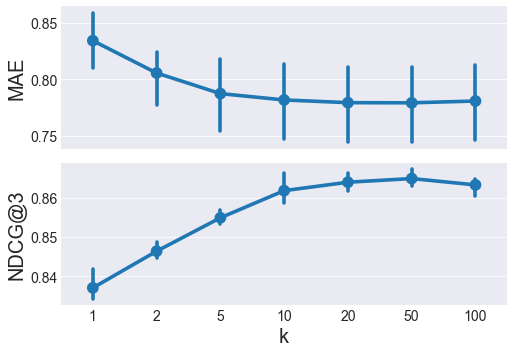

In [9]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=user_results_df, x='k', y='test_err', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
sns.pointplot(data=user_results_df, x='k', y='ndcg_mean', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
fig.subplots_adjust(hspace=0.1)
plt.show()

NDCG@3 peaks at $k=50$, and MAE is pretty similar between $k=20$ to $100$, so $k=50$ is the winner.

In [10]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
best_user_model = KNNRecommender(mode='user', k=50, baseline_algo=baseline_algo)

# 4. Choose the best item-based model

Let's use cross-validation to examine MAE and NDCG@3 on out-of-sample data and choose the "best" item-based model.

In [11]:
lists_dict = {
    'i_fold': np.arange(n_splits),
    'k': [1, 2, 5, 10, 20, 50, 100],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
item_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    item_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    item_results_i = item_results_df[item_results_df['i_fold']==i_fold]
    print("i_fold={}: ".format(i_fold), end='')
    for index, row in item_results_i[['i_fold', 'k']].iterrows():
        t1 = datetime.now()
        model = KNNRecommender(mode='item', k=row['k'], baseline_algo=baseline_algo)
        preds = model.fit(train_df).predict(test_df[['userId', 'movieId']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        print("k={}, ".format(row['k']), end='')
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        item_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt
    print()

i_fold=0: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=1: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=2: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 


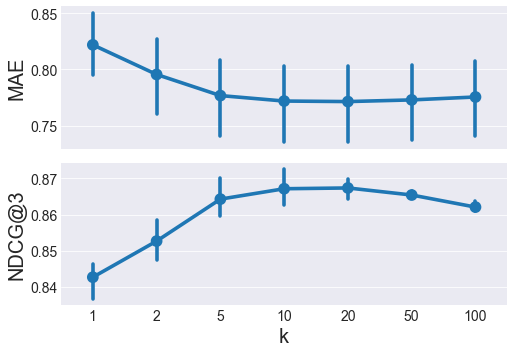

In [12]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=item_results_df, x='k', y='test_err', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
sns.pointplot(data=item_results_df, x='k', y='ndcg_mean', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
fig.subplots_adjust(hspace=0.1)
plt.show()

Here, $k=10$ and $k=20$ have similar MAE and NDCG@3, we'll favor higher $k$ in nearest neigbor methods because higher $k$ is less prone to overfitting. $k=20$ is the winner of the item-based models.

In [13]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
best_item_model = KNNRecommender(mode='item', k=20, baseline_algo=baseline_algo)

# 5. Choose the best ALS model

Let's use cross-validation to examine MAE and NDCG@3 on out-of-sample data and choose the "best" ALS model.

In [14]:
max_epochs = 15
lists_dict = {
    'i_fold': np.arange(n_splits),
    'i_epoch': np.arange(max_epochs),
    'k': [5, 10, 50],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
als_epoch_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    als_epoch_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    als_epoch_results_i = als_epoch_results_df[als_epoch_results_df['i_fold']==i_fold]
    for k, group in als_epoch_results_i.groupby('k'):
        model = ALSRecommender(k=k, lmbda=0.1, max_epochs=max_epochs, baseline_algo=baseline_algo,
                             verbose=False)
        print('i_fold={}, k={}: i_epoch='.format(i_fold, k), end='')
        for index, row in group[['i_fold', 'i_epoch']].iterrows():
            t1 = datetime.now()
            preds = model.fit(train_df, n_epochs=1).predict(test_df[['userId', 'movieId']])
            dt = (datetime.now() - t1).total_seconds()
            test_err = mean_absolute_error(test_df['rating'], preds)
            user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
            ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
            print('{}, '.format(row['i_epoch']), end='')
            cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
            als_epoch_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt
        print()

i_fold=0, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 


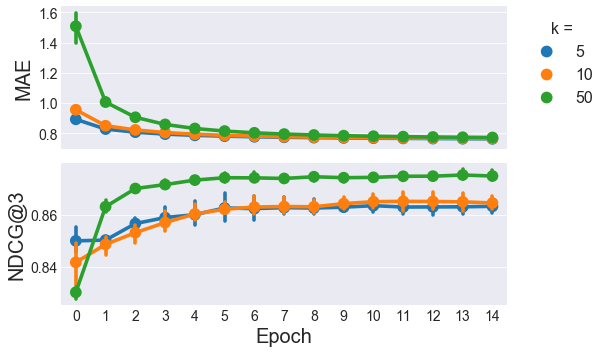

In [15]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=als_epoch_results_df, x='i_epoch', y='test_err', hue='k', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='k =')
sns.pointplot(data=als_epoch_results_df, x='i_epoch', y='ndcg_mean', hue='k', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.set_xlabel('Epoch')
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

In [16]:
max_epochs = 15
lists_dict = {
    'i_fold': np.arange(n_splits),
    'k': [20, 50, 100, 200],
    'lmbda': [0.05, 0.1, 0.2]
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
als_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    als_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    als_results_i = als_results_df[als_results_df['i_fold']==i_fold]
    for index, row in als_results_i[['k', 'lmbda']].iterrows():
        model = ALSRecommender(k=row['k'], lmbda=row['lmbda'], max_epochs=max_epochs, baseline_algo=baseline_algo,
                               verbose=False)
        print('i_fold={}, k={}: lmbda={}'.format(i_fold, row['k'], row['lmbda']))
        t1 = datetime.now()
        preds = model.fit(train_df).predict(test_df[['userId', 'movieId']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        als_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt

i_fold=0, k=20.0: lmbda=0.05
i_fold=0, k=20.0: lmbda=0.1
i_fold=0, k=20.0: lmbda=0.2
i_fold=0, k=50.0: lmbda=0.05
i_fold=0, k=50.0: lmbda=0.1
i_fold=0, k=50.0: lmbda=0.2
i_fold=0, k=100.0: lmbda=0.05
i_fold=0, k=100.0: lmbda=0.1
i_fold=0, k=100.0: lmbda=0.2
i_fold=0, k=200.0: lmbda=0.05
i_fold=0, k=200.0: lmbda=0.1
i_fold=0, k=200.0: lmbda=0.2
i_fold=1, k=20.0: lmbda=0.05
i_fold=1, k=20.0: lmbda=0.1
i_fold=1, k=20.0: lmbda=0.2
i_fold=1, k=50.0: lmbda=0.05
i_fold=1, k=50.0: lmbda=0.1
i_fold=1, k=50.0: lmbda=0.2
i_fold=1, k=100.0: lmbda=0.05
i_fold=1, k=100.0: lmbda=0.1
i_fold=1, k=100.0: lmbda=0.2
i_fold=1, k=200.0: lmbda=0.05
i_fold=1, k=200.0: lmbda=0.1
i_fold=1, k=200.0: lmbda=0.2
i_fold=2, k=20.0: lmbda=0.05
i_fold=2, k=20.0: lmbda=0.1
i_fold=2, k=20.0: lmbda=0.2
i_fold=2, k=50.0: lmbda=0.05
i_fold=2, k=50.0: lmbda=0.1
i_fold=2, k=50.0: lmbda=0.2
i_fold=2, k=100.0: lmbda=0.05
i_fold=2, k=100.0: lmbda=0.1
i_fold=2, k=100.0: lmbda=0.2
i_fold=2, k=200.0: lmbda=0.05
i_fold=2, k=200.0: l

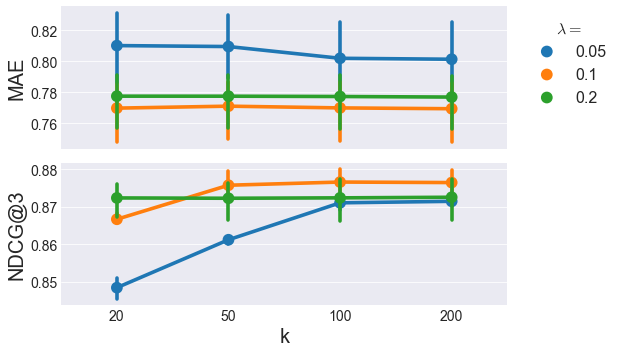

In [17]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=als_results_df, x='k', y='test_err', hue='lmbda', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title=r'$\lambda =$')
sns.pointplot(data=als_results_df, x='k', y='ndcg_mean', hue='lmbda', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

Here, it looks like MAE is pretty flat with respect to the learning rate $\lambda$, but NDCG@3 shows some interesting variations. The highest NDCG@3 comes from $\lambda=0.1$ and $k>=50$. With matrix factorization methods like ALS, we want to favor lower $k$ for better generalizability, so $\lambda=0.1$ and $k=50$ is the winner of the ALS category.

In [18]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
best_als_model = ALSRecommender(k=50, lmbda=0.1, max_epochs=15, baseline_algo=baseline_algo)

# 6. Choose the best SGD model

Let's use cross-validation to examine MAE and NDCG@3 on out-of-sample data and choose the "best" SGD model.

In [20]:
max_epochs = 15
lists_dict = {
    'i_fold': np.arange(n_splits),
    'i_epoch': np.arange(max_epochs),
    'k': [5, 10, 50],
}
k_recs = 3
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
sgd_epoch_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    sgd_epoch_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    sgd_epoch_results_i = sgd_epoch_results_df[sgd_epoch_results_df['i_fold']==i_fold]
    for k, group in sgd_epoch_results_i.groupby('k'):
        model = SGDRecommender(k=k, learning_rate=0.01, max_epochs=max_epochs, damping_factor=10,
                               verbose=False)
        print('i_fold={}, k={}: i_epoch='.format(i_fold, k), end='')
        for index, row in group[['i_fold', 'i_epoch']].iterrows():
            t1 = datetime.now()
            preds = model.fit(train_df, n_epochs=1).predict(test_df[['userId', 'movieId']])
            dt = (datetime.now() - t1).total_seconds()
            test_err = mean_absolute_error(test_df['rating'], preds)
            user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
            ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
            print('{}, '.format(row['i_epoch']), end='')
            cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
            sgd_epoch_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt
        print()

i_fold=0, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=0, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=1, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=5: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=10: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
i_fold=2, k=50: i_epoch=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 


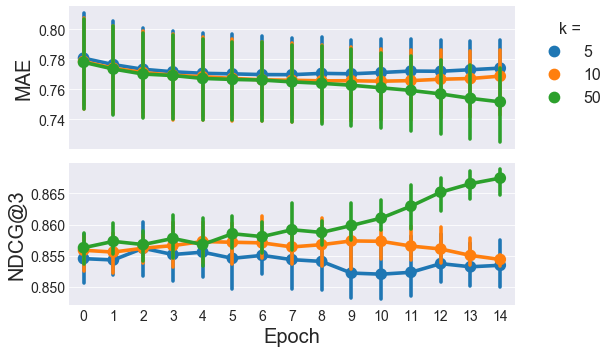

In [24]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=sgd_epoch_results_df, x='i_epoch', y='test_err', hue='k', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='k =')
sns.pointplot(data=sgd_epoch_results_df, x='i_epoch', y='ndcg_mean', hue='k', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.set_xlabel('Epoch')
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

In [25]:
lists_dict = {
    'i_fold': np.arange(n_splits),
    'learning_rate': [0.001, 0.01],
    'reg': [0.0, 0.001, 0.01],
}
k_recs = 3
k = 50
max_epochs = 30
sgd_results_df = prep_results_df(lists_dict)
cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
for c in cols:
    sgd_results_df[c] = np.nan
for i_fold, (train_inds, test_inds) in enumerate(splits):
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    sgd_results_i = sgd_results_df[sgd_results_df['i_fold']==i_fold]
    for index, row in sgd_results_i[['learning_rate', 'reg']].iterrows():
        learning_rate, reg = row['learning_rate'], row['reg']
        model = SGDRecommender(k=k, learning_rate=learning_rate, max_epochs=max_epochs,
                               damping_factor=10, verbose=False,
                               user_reg=reg, item_reg=reg, user_bias_reg=reg, item_bias_reg=reg)
        print('i_fold={}, learning_rate={}, reg={}'.format(i_fold, learning_rate, reg))
        t1 = datetime.now()
        preds = model.fit(train_df).predict(test_df[['userId', 'movieId']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=k_recs)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        cols = ['test_err', 'ndcg_mean', 'ndcg_std', 'dt']
        sgd_results_df.loc[index, cols] = test_err, ndcg_mean, ndcg_std, dt

i_fold=0, learning_rate=0.001, reg=0.0
i_fold=0, learning_rate=0.001, reg=0.001
i_fold=0, learning_rate=0.001, reg=0.01
i_fold=0, learning_rate=0.01, reg=0.0
i_fold=0, learning_rate=0.01, reg=0.001
i_fold=0, learning_rate=0.01, reg=0.01
i_fold=1, learning_rate=0.001, reg=0.0
i_fold=1, learning_rate=0.001, reg=0.001
i_fold=1, learning_rate=0.001, reg=0.01
i_fold=1, learning_rate=0.01, reg=0.0
i_fold=1, learning_rate=0.01, reg=0.001
i_fold=1, learning_rate=0.01, reg=0.01
i_fold=2, learning_rate=0.001, reg=0.0
i_fold=2, learning_rate=0.001, reg=0.001
i_fold=2, learning_rate=0.001, reg=0.01
i_fold=2, learning_rate=0.01, reg=0.0
i_fold=2, learning_rate=0.01, reg=0.001
i_fold=2, learning_rate=0.01, reg=0.01


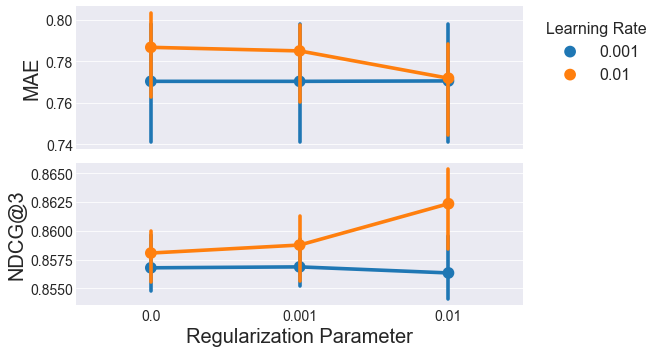

In [26]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=sgd_results_df, x='reg', y='test_err', hue='learning_rate', ax=ax0)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax0.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Learning Rate')
sns.pointplot(data=sgd_results_df, x='reg', y='ndcg_mean', hue='learning_rate', ax=ax1)
ax1.set_ylabel('NDCG@{}'.format(k_recs))
ax1.set_xlabel('Regularization Parameter')
ax1.legend_.remove()
fig.subplots_adjust(hspace=0.1)
plt.show()

In [27]:
reg = 0.01
best_sgd_model = SGDRecommender(k=50, learning_rate=0.01, max_epochs=30, damping_factor=10,
                                user_reg=reg, item_reg=reg, user_bias_reg=reg, item_bias_reg=reg)

# 7. Let's compare the top methods of each category.

In [28]:
final_models = [best_user_model, best_item_model, best_als_model, best_sgd_model]
final_model_names = ['user', 'item', 'als', 'sgd']
final_results = pd.DataFrame(columns=['model', 'i_fold', 'test_err', 'ndcg_mean', 'ndcg_std', 'dt'])
for model, name in zip(final_models, final_model_names):
    for i_fold, (train_inds, test_inds) in enumerate(splits):
        print("i_fold={}, model={}".format(i_fold, name))
        train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
        if name in ['als', 'sgd']:
            model.verbose = False
        t1 = datetime.now()
        preds = model.fit(train_df).predict(test_df[['userId', 'movieId']])
        dt = (datetime.now() - t1).total_seconds()
        test_err = mean_absolute_error(test_df['rating'], preds)
        user_map, ndcg_array = ndcg_from_df(test_df, preds, k=3)
        ndcg_mean, ndcg_std = np.mean(ndcg_array), np.std(ndcg_array)
        final_results.loc[len(final_results), :] = name, i_fold, test_err, ndcg_mean, ndcg_std, dt

i_fold=0, model=user
i_fold=1, model=user
i_fold=2, model=user
i_fold=0, model=item
i_fold=1, model=item
i_fold=2, model=item
i_fold=0, model=als
i_fold=1, model=als
i_fold=2, model=als
i_fold=0, model=sgd
i_fold=1, model=sgd
i_fold=2, model=sgd


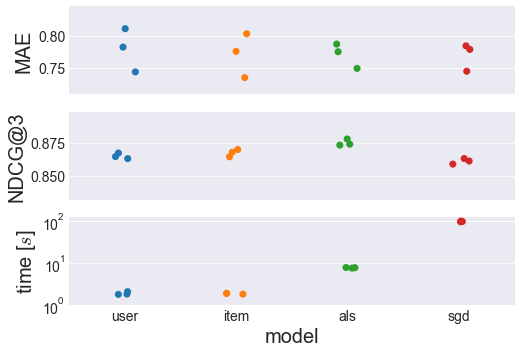

In [30]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True)
sns.stripplot(data=final_results, x='model', y='test_err', ax=ax0, jitter=True)
sns.stripplot(data=final_results, x='model', y='ndcg_mean', ax=ax1, jitter=True)
sns.stripplot(data=final_results, x='model', y='dt', ax=ax2, jitter=True)
ax0.set_ylabel('MAE')
ax0.set_xlabel('')
ax1.set_ylabel('NDCG@3')
ax1.set_xlabel('')
ax2.set_ylabel(r'time [$s$]')
ax2.set(yscale='log')
ax2.set_yticks([1, 10, 100])
plt.setp(ax0.collections, sizes=[50])
plt.setp(ax1.collections, sizes=[50])
plt.setp(ax2.collections, sizes=[50])
plt.show()

There's a lot of information in the 3 charts above. The charts show 3 different metrics (Mean Absolute Error, Normalized Discounted Cumulative Gain, and time) for the best user-based, item-based, ALS, and SGD models I found. Each metric/model combination has 3 points, representing the values for each of the 3 folds used for cross-validation.

The MAE doesn't seem to change much across the different models, although the variance seems to be slightly smaller for the matrix factorization methods (ALS and SGD) compared to the nearest neighbors methods (user-based and item-based).

The NDCG@3 does seem to vary across the different models though, with the highest score going to the ALS model. NDCG@3 is arguably the more useful metric for a recommender system, so as long as very high speeds aren't important, ALS wins here.

If this ALS model is too slow for a particular application, the item-based method would be the next choice. Both user- and item-based recommenders have similarly fast training speeds, with item-based having a slightly higher NDCG@3 score. The slower execution of the ALS and SGD models are likely related to the number of iterations over for loops required in each iteration.

As they are right now, my user- and item-based models don't need any python for loops during training. ALS has $n_{users} + n_{movies}$ python for loop iterations per epoch, and SGD has $n_{ratings}$ iterations per epoch, which is about an order of magnitude higher. I specify "python" for loops, because the vectorized operations used in user-based, item-based, and ALS models have for loops in c which are much faster than those in python. By optimizing code with something like cython or numba, I could certainly drop the training time for ALS and SGD.

If you want to play with these models interactively, check out [my recommender notebook](https://github.com/benlindsay/movielens-analysis/blob/master/07_Recommender.ipynb). With this notebook, you could choose whichever user you want, show some of their favorite movies, then display the top recommendations given by any of these 4 models.